# Anaconda 환경에서 xgboost 설치 
- Anaconda Prompt 관리자 권한으로 실행 후 pip install xgboost , pip install lightgbm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [3]:
data = load_breast_cancer().data
target = load_breast_cancer().target
columns = load_breast_cancer().feature_names

In [4]:
print(data.shape)
print(columns)

(569, 30)
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [5]:
data = (data - data.mean(axis = 0)) / data.std(axis = 0)

In [6]:
clfs = []
abm = AdaBoostClassifier(random_state = 5); clfs.append(abm)
gbm = GradientBoostingClassifier(random_state = 5); clfs.append(gbm)
xgb = XGBClassifier(random_state = 5); clfs.append(xgb)
lgb = LGBMClassifier(random_state = 5); clfs.append(lgb)

# Holdout

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, stratify = target, random_state=725)

In [8]:
pred_results=[]             
for clf in clfs:
    clf.fit(X_train, y_train)
    pred_proba = clf.predict_proba(X_val)[:, 1]
    pred = clf.predict(X_val)
    name = type(clf).__name__
    pred_results.append(pd.Series(pred_proba, name = name))
    print('model : %s\n\t\t\t\tlogloss : %.4f, accuracy : %.4f'%(name, log_loss(y_val, pred), accuracy_score(y_val, pred)))

model : AdaBoostClassifier
				logloss : 1.5149, accuracy : 0.9561
model : GradientBoostingClassifier
				logloss : 0.9089, accuracy : 0.9737
model : XGBClassifier
				logloss : 0.9089, accuracy : 0.9737
model : LGBMClassifier
				logloss : 0.6060, accuracy : 0.9825


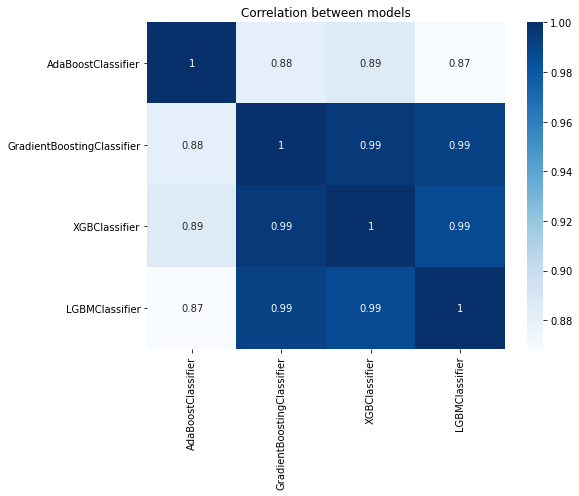

In [9]:
results=pd.concat(pred_results, axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(results.corr(), annot=True, cmap='Blues')
plt.title('Correlation between models')
plt.show()

# CrossValidation

In [10]:
kfold = StratifiedKFold(n_splits = 4, random_state = 5)

In [11]:
for clf in clfs:
    score = cross_val_score(clf, data, target, cv = kfold, scoring = 'accuracy').mean()
    name = type(clf).__name__
    print('model : %s\n\t\t\t\taccuracy : %f'%(name, score))

model : AdaBoostClassifier
				accuracy : 0.966660
model : GradientBoostingClassifier
				accuracy : 0.963139
model : XGBClassifier
				accuracy : 0.964887
model : LGBMClassifier
				accuracy : 0.964912


In [12]:
clf_names=[type(clf).__name__ for clf in clfs]
for clf in clfs:
    score = []
    for train_idx, val_idx in kfold.split(X_train, y_train):
        t, v = data[train_idx], data[val_idx]
        y_t, y_v = target[train_idx], target[val_idx]
        clf.fit(t, y_t)
        pred=clf.predict(v)
        acc = accuracy_score(y_v, pred)
        
        score.append(acc)

    score = np.mean(score)
    name = type(clf).__name__
    print('model : %s\n\t\t\t\taccuracy : %f'%(name, score))

model : AdaBoostClassifier
				accuracy : 0.962661
model : GradientBoostingClassifier
				accuracy : 0.942866
model : XGBClassifier
				accuracy : 0.951619
model : LGBMClassifier
				accuracy : 0.958275


In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
abm_params ={'n_estimators' : [50,100,200,300],
         'learning_rate' : [0.04, 0.01, 0.1 ,0.4]
        }
grid=GridSearchCV(abm, abm_params, scoring='accuracy', cv=kfold, n_jobs=-1)
grid.fit(data, target)
abm=grid.best_estimator_
print(grid.best_estimator_)
print(grid.best_score_)

AdaBoostClassifier(learning_rate=0.4, n_estimators=200, random_state=5)
0.9718925440756427


In [15]:
gbm_params= {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],
        'max_features': (np.arange(0.5, 1.0, 0.1)*data.shape[1]).astype(int)}
grid=GridSearchCV(gbm, gbm_params, scoring='accuracy', cv=kfold, n_jobs=-1)
grid.fit(data, target)
gbm=grid.best_estimator_
print(grid.best_estimator_)
print(grid.best_score_)

GradientBoostingClassifier(learning_rate=1, max_features=26, n_estimators=300,
                           random_state=5)
0.975438294100266


In [16]:
xgb_params= {'min_child_weight': range(0, 121, 20),
         'learning_rate': np.arange(0.1, 0.6, 0.1),
         'subsample': np.arange(0.5, 1.0, 0.1)}
grid=GridSearchCV(xgb, xgb_params, scoring='accuracy', cv=kfold, n_jobs=-1)
grid.fit(data, target)
xgb=grid.best_estimator_
print(grid.best_estimator_)
print(grid.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=6,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=5,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)
0.975438294100266


In [17]:
lgb_params= {'min_child_weight': range(0, 121, 20),
         'learning_rate': np.arange(0.1, 0.6, 0.1),
         'subsample': np.arange(0.5, 1.0, 0.1)}
grid=GridSearchCV(lgb, lgb_params, scoring='accuracy', cv=kfold, n_jobs=-1)
grid.fit(data, target)
lgb=grid.best_estimator_
print(grid.best_estimator_)
print(grid.best_score_)

LGBMClassifier(learning_rate=0.30000000000000004, min_child_weight=0,
               random_state=5, subsample=0.5)
0.9719294789717325


In [18]:
clfs = []; clfs.append(abm); clfs.append(gbm); clfs.append(xgb); clfs.append(lgb)

for clf in clfs:
    score = cross_val_score(clf, data, target, cv = kfold, scoring = 'accuracy').mean()
    name = type(clf).__name__
    print('model : %s\n\t\t\t\taccuracy : %f'%(name, score))

model : AdaBoostClassifier
				accuracy : 0.971893
model : GradientBoostingClassifier
				accuracy : 0.975438
model : XGBClassifier
				accuracy : 0.975438
model : LGBMClassifier
				accuracy : 0.971929


## Hyper Parameters

- Adaptive Boost : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
- Gradient Boost : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- XGBOOST : https://xgboost.readthedocs.io/en/latest/parameter.html
- Light GBM : https://lightgbm.readthedocs.io/en/latest/Parameters.html

#### AdaBoost 

1. learning rate(python) or eta(in r) : 학습률, ↓ : Over Fitting 가능성 ↓, 학습속도 slow(0 ~ 1) <br> <br>
2. n_estimator : 최대 tree 개수, ↓ : Over Fitting 가능성 ↑, 학습속도 fast(정수)                          m                                                    

#### GBM Parameters 

1. learning rate(python) or eta(in r) : 학습률, ↓ : Over Fitting 가능성 ↓, 학습속도 slow(0 ~ 1)<br>
<br>
2. max_depth : 트리의 최대 깊이, ↓ : Over Fitting 가능성 ↓, 학습속도 slow (정수)<br>
<br>
3. subsample : train에 쓸 instance의 비율, ↓ : Over Fitting 가능성 ↑, 학습속도 fast (0 ~ 1)<br>
<br>
4. n_estimator : 최대 tree 개수, ↓ : Over Fitting 가능성 ↑, 학습속도 fast(정수)


#### XGB Parameters

1. learning rate(python) or eta(in r) : 학습률 ,↓ : Over Fitting 가능성 ↓, 학습속도 slow(0 ~ 1) <br> <br>
2. max_depth : tree의 최대깊이 ↓ : Over Fitting 가능성 ↑, 학습속도 fast(0 ~ 1) <br> <br>
3. min_child_weight : 트리에서 가지를 추가로 치기위해 필요한 최소한의 사례 수 ↓ : Over Fitting 가능성 ↓, 학습속도 slow(정수) <br> <br>
4. colsample_bytree : 각 트리를 만들 때, 전체 데이터에서 사용할 열(column)의 비율 ↓ : Over Fitting 가능성 ↑, 학습속도 fast(0 ~ 1) <br> <br>

5. n_estimators : 최대 tree 개수 ↓ : Over Fitting 가능성 ↓, 학습속도 fast(정수) <br> <br>



#### Light XGB Parameters

1. learning rate(python) or eta(in r) : 학습률 ↓ : Over Fitting 가능성 ↓, 학습속도 slow(0 ~ 1) <br> <br>
2. max_depth : tree의 최대깊이 ↓ : Over Fitting 가능성 ↓, 학습속도 fast(정수) <br> <br>
3. num_leaves : leaf의 최대개수 ↓ : Over Fitting 가능성 ↓, 학습속도 fast(정수) <br> <br>

4. min_data_in_leaf : 잎을 추가로 만들기 위해 필요한 최소한의 사례 수 ↓ : Over Fitting 가능성 ↑, 학습속도 slow(정수)

 


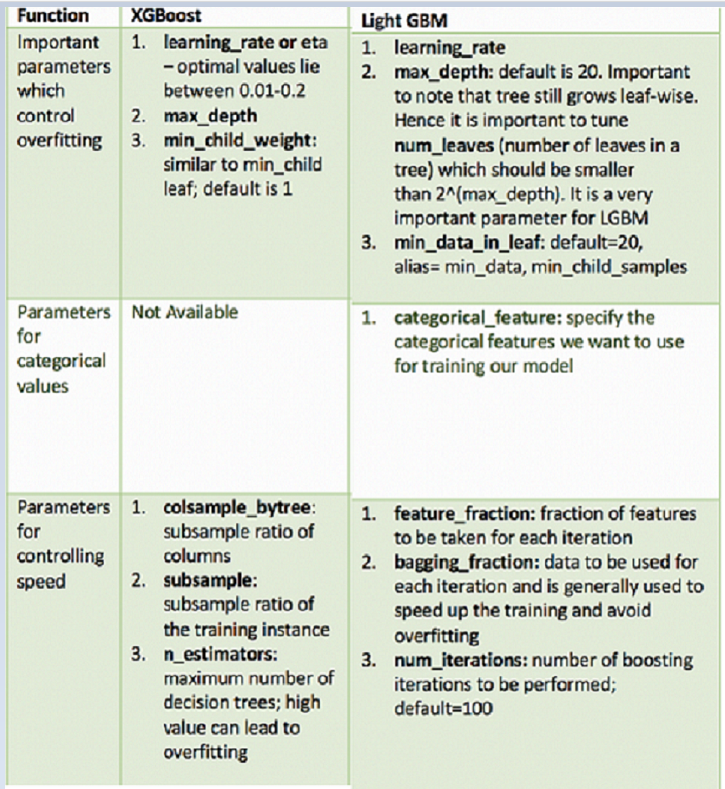

In [19]:
type(abm).__name__

'AdaBoostClassifier'

## Feature Importance

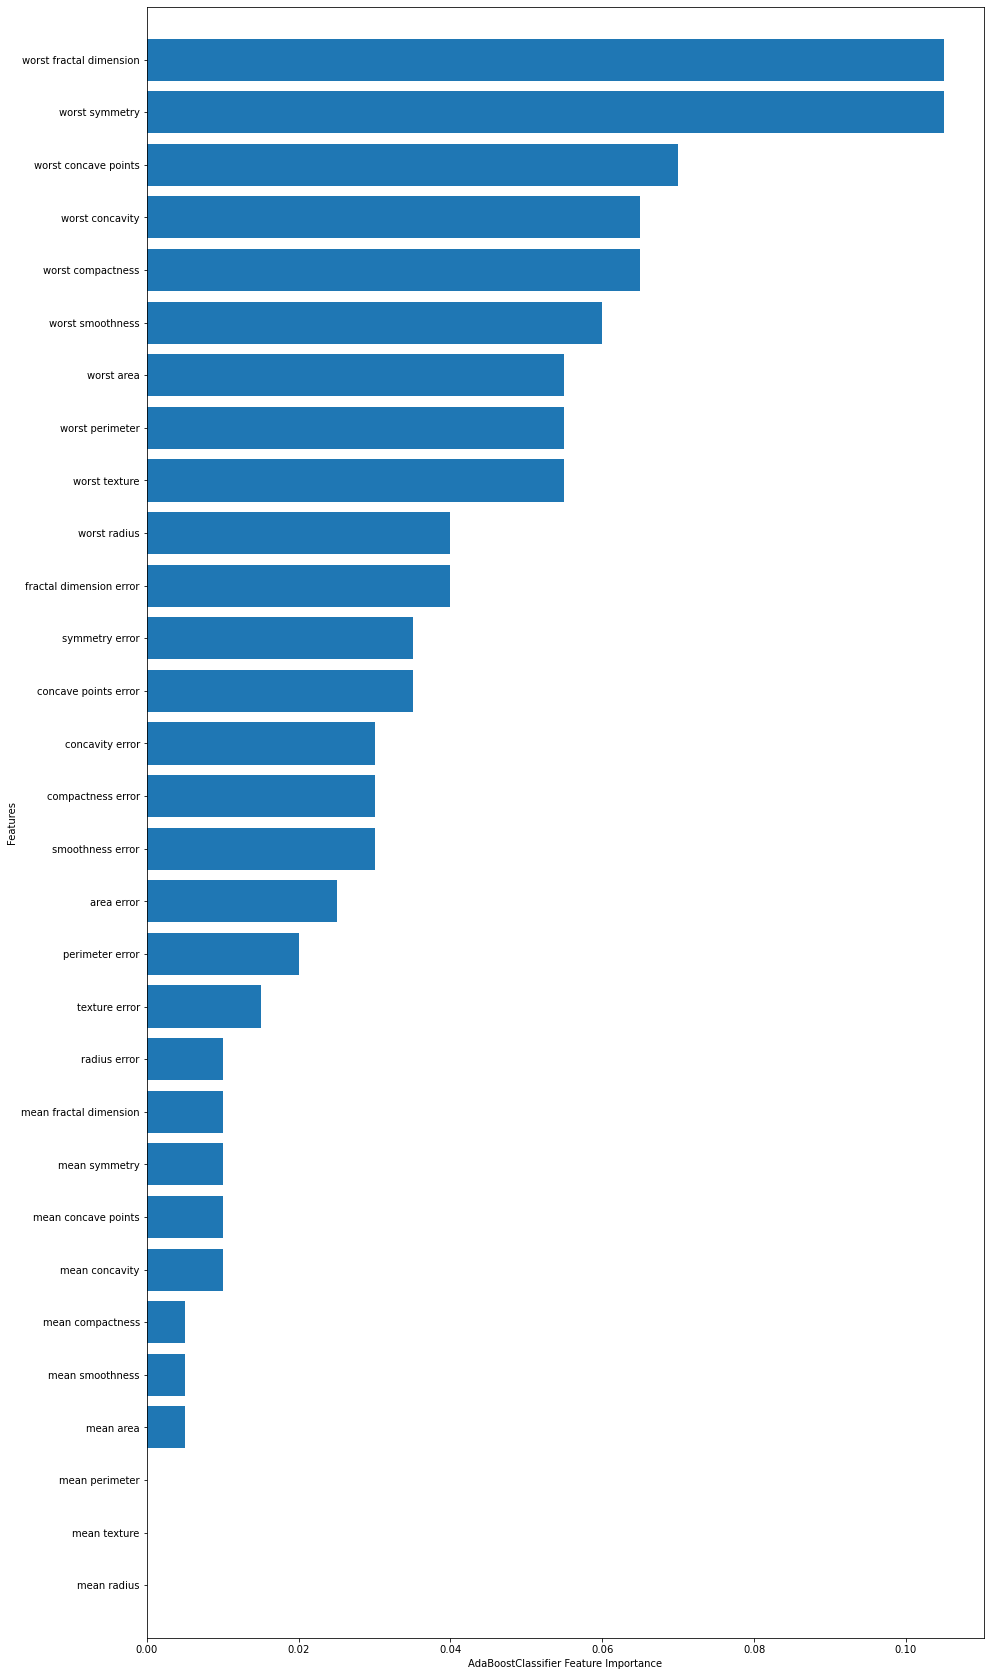

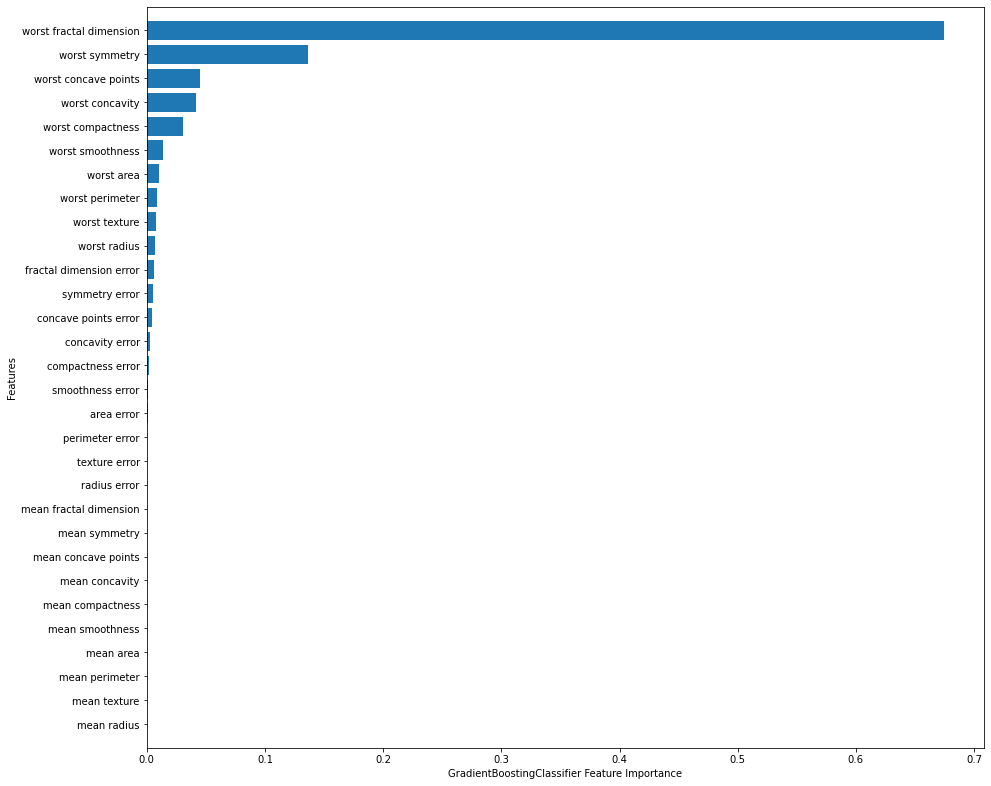

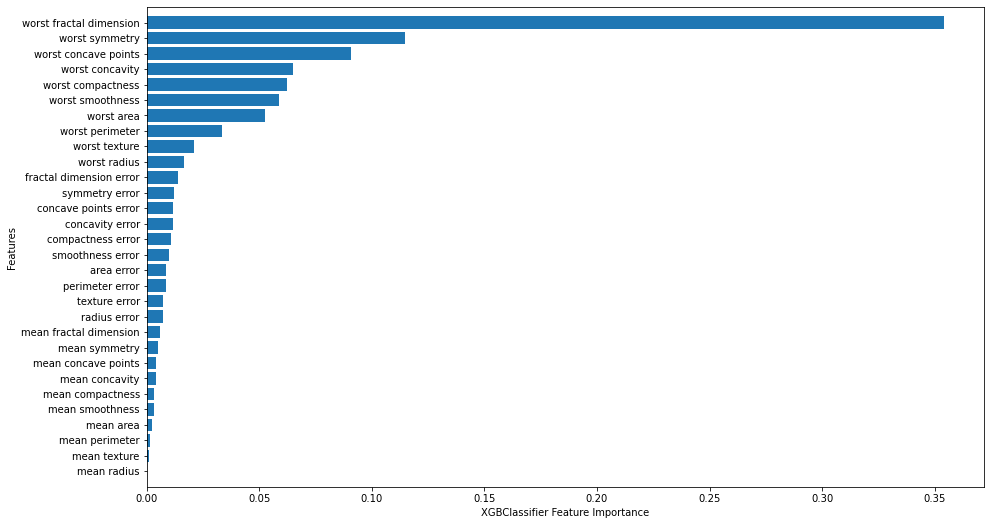

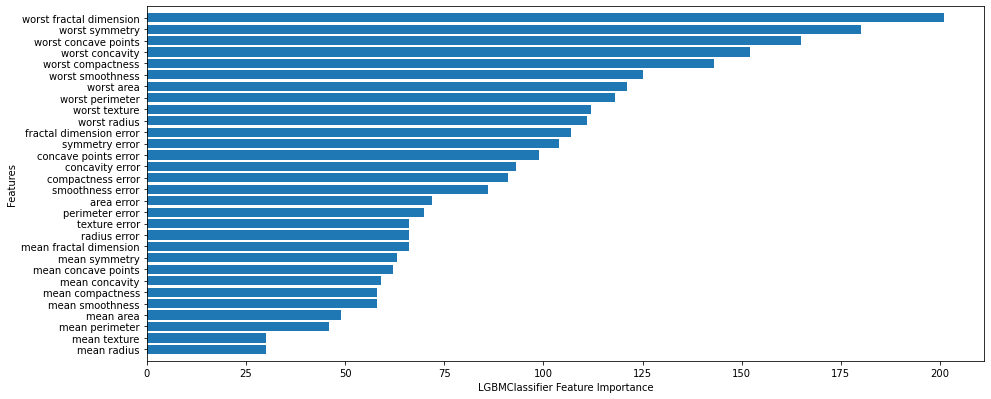

In [20]:
n_features = data.shape[1]
for i, clf in enumerate(clfs) :
    name = type(clf).__name__
    plt.figure(figsize=(15, 30))
    plt.subplot(i+1,1,1) 
    plt.barh(np.arange(n_features), sorted(clf.feature_importances_), align = 'center')
    plt.yticks(np.arange(n_features), columns)
    plt.xlabel('{} Feature Importance'.format(name))
    plt.ylabel('Features')
    plt.ylim(-1, n_features)
    plt.show()